# EVALUER UNE FREQUENCE DE MAINTENANCE

Dans les fichiers précédents, nous avons exploré les données pour les regrouper en une table exploitable, puis nous avons testé plusieurs modèles de clusterisation. 

- On va repartir du tableau de synthèse des commandes : 
   - On va sélectionner une base de départ (les commandes avant 2018) 
- Le retransformer en tableau de synthèses des clients
- Appliquer notre clusterisation

Ensuite, on va étendre notre base de départ à l'ensemble des commandes réalisées le mois suivant, puis réitérer. Cela va nous permettre d'evaluer comment le drift des donnees influe sur notre modele de segmentation afin d'etablir d'une frequence de maintenance ad hoc.

# 0. Includes et fonctions globales

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

# Libraires Scikit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Ajouter facilement un time_delta
from dateutil.relativedelta import relativedelta

# ARI pour mesurer l'évolution de notre labelling
from sklearn.metrics.cluster import adjusted_rand_score

In [2]:
# Permet de transformer la date de dernier achat en "recence", i.e le nombre de jour qui separe le derniere achat de DATEREF
DATEREF = dt.datetime(2019, 1, 1, 0, 0, 0)

# On va fixer certains parametres du KMEANS pour s'assurer de chercher le meilleur k dans une configuration maitrisee.
KMEANS_NINIT = 10
KMEANS_RANDSTATE = 10

In [3]:
def creer_tableau_synthese(df_ini, date_ref = DATEREF) :
    # Montant total depense par client
    synthese_df = df_ini.groupby(by='customer_unique_id')['payment_value'].sum().reset_index()
    
    # Frequence d'achat (ou plutot nombre de commandes)
    nb_commandes = df_ini['customer_unique_id'].value_counts().reset_index()
    nb_commandes.rename(columns={'count' : 'nbcommandes'}, inplace=True)
    synthese_df = synthese_df.merge(nb_commandes, on='customer_unique_id', how='left')

    # Date de dernier achat (Recence)
    df_ini = df_ini.sort_values(by='order_purchase_timestamp', ascending=False)
    tmp = df_ini[~df_ini['customer_unique_id'].duplicated(keep='first')]
    tmp = tmp[['order_purchase_timestamp', 'customer_unique_id']]
    synthese_df = synthese_df.merge(tmp, on='customer_unique_id', how='left')
    # Transforme date de dernier achat en recence
    synthese_df['recence'] = (date_ref - synthese_df['order_purchase_timestamp']).apply(lambda x: x.days)
    synthese_df.drop(columns = ['order_purchase_timestamp'], inplace = True)

    # Avis moyen
    tmp = df_ini.groupby('customer_unique_id')['review_score'].mean().reset_index()
    synthese_df = synthese_df.merge(tmp, on='customer_unique_id', how='left')

    # Nombre moyen d'item par commande
    tmp = df_ini.groupby('customer_unique_id')['nb_items'].mean().reset_index()
    synthese_df = synthese_df.merge(tmp, on='customer_unique_id', how='left')

    # Nombre de reducs utilisees
    tmp = df_ini.groupby('customer_unique_id')['reducs'].sum().reset_index()
    synthese_df = synthese_df.merge(tmp, on='customer_unique_id', how='left')
    # # on dummyfie l'utilisation de reductions
    # synthese_df.loc[synthese_df['reducs'] > 0] = 1


    # Montant total des reducs utilisees
    tmp = df_ini.groupby('customer_unique_id')['montant_reducs'].sum().reset_index()
    synthese_df = synthese_df.merge(tmp, on='customer_unique_id', how='left')
    # Categorie preferee du client
    # On cree un tableau qui croise le nombre d'occurences des categories en fonction des references clients
    tmp_xtab = pd.crosstab(df_ini['cat_produit'], df_ini['customer_unique_id'])
    tmp = tmp_xtab.idxmax().reset_index()
    tmp.rename(columns={0 : 'categorie_produit_preferee'}, inplace=True)
    synthese_df = synthese_df.merge(tmp, on='customer_unique_id', how='left')
    # Rennommage des colonnes pour lisibilite
    synthese_df.rename(columns={'customer_unique_id' : 'client', 'payment_value' : 'depense', 'review_score' : 'avis_moyen', 'nb_items' : 'nb_items_moyen'}, inplace=True)
    
    return synthese_df

# 1. Tableau de synthèse des commandes

In [4]:
df = pd.read_csv('./data_travail/df_merged.csv')
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'],yearfirst=True)

In [5]:
print("Date min : " , df['order_purchase_timestamp'].min())
print("Date max : " , df['order_purchase_timestamp'].max())
print("nb Commandes : " , df.shape[0])
print("Jours qui separent la date min de la date max du dataset : ", (df['order_purchase_timestamp'].max() - df['order_purchase_timestamp'].min()).days)

Date min :  2016-09-15 12:16:38
Date max :  2018-08-29 15:00:37
nb Commandes :  96478
Jours qui separent la date min de la date max du dataset :  713


On a un peu moins de deux ans de donnnées. 

On faire comme si notre clusterisation commençait le 1/1/2018.
- puis on ajoutera, chaque mois, les donnees du mois passé. 
- Et on fera notre clusterisation pour estimer l'ARI

In [6]:
date_seuil_0 = dt.datetime(2018, 1, 1, 0, 0, 0)
df_t0 = df[df['order_purchase_timestamp'] < date_seuil_0]
print("Nb commandes sous date seuil : ", df_t0.shape[0])

Nb commandes sous date seuil :  43695


# 2. Évolution de la clusterisation en 8 mois

Dans ce fichier, on ne va realiser notre analyse que pour le 7-Means. Mais on pourrait aussi utiliser cette methode pour nous aider choisir un algorithme de clusterisation qui necessite le moins de maintenance possible

## 2.1. K-Means, avec k=7

In [7]:
n_clusters = 7

In [8]:
dfc = creer_tableau_synthese(df_ini=df, date_ref=DATEREF)
dfc.head(2)

,client,depense,nbcommandes,recence,avis_moyen,nb_items_moyen,reducs,montant_reducs,categorie_produit_preferee
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,1,235,5.0,1.0,0.0,0.0,bed_bath_table
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,238,4.0,1.0,0.0,0.0,health_beauty


In [9]:
ref_clients = pd.DataFrame()
ref_clients['client'] = dfc['client']
new_date = date_seuil_0

for i in range(0, 8) : 
    # Faire evoluer la date
    new_date = date_seuil_0 + relativedelta(months=i)
    DATEREF = new_date
    # Faire evoluer le tableau de commandes
    df_current = df[df['order_purchase_timestamp'] < DATEREF]
    # Generer une nouvelle synthese client
    sdf = creer_tableau_synthese(df_ini=df_current, date_ref=DATEREF)
    # Realiser un clustering
    dfw = sdf.drop(columns=['client', 'categorie_produit_preferee', 'reducs', 'montant_reducs'])
    X = dfw.values
    X_scaled = StandardScaler().fit_transform(X)
    if i == 0 : # On initie le model au debut
        model = KMeans(n_init = KMEANS_NINIT, n_clusters=n_clusters, random_state=KMEANS_RANDSTATE)
        model.fit(X_scaled)
    # Sauvegarder les resultats
    sdf.loc[:, f'k7_labels_iter_{i}'] = model.predict(X_scaled)
    ref_clients = ref_clients.merge(sdf[['client', f'k7_labels_iter_{i}']], on='client', how='left')


In [10]:
ref_clients.isna().sum()

client                  0
k7_labels_iter_0    50963
k7_labels_iter_1    44121
k7_labels_iter_2    37833
k7_labels_iter_3    31059
k7_labels_iter_4    24477
k7_labels_iter_5    17971
k7_labels_iter_6    12093
k7_labels_iter_7     6144
dtype: int64

Chaque mois, on gagne entre 5 et 7 mille clients.

In [11]:
anciens_clients = ref_clients[~ref_clients['k7_labels_iter_0'].isna()]

In [12]:
anciens_clients.head(5)

,client,k7_labels_iter_0,k7_labels_iter_1,k7_labels_iter_2,k7_labels_iter_3,k7_labels_iter_4,k7_labels_iter_5,k7_labels_iter_6,k7_labels_iter_7
2,0000f46a3911fa3c0805444483337064,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,6.0,6.0,6.0,6.0,6.0,1.0,1.0,1.0
4,0004aac84e0df4da2b147fca70cf8255,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1.0
8,0005e1862207bf6ccc02e4228effd9a0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
10,0006fdc98a402fceb4eb0ee528f6a8d4,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0


In [13]:
print(adjusted_rand_score(anciens_clients['k7_labels_iter_0'], anciens_clients['k7_labels_iter_1']))
print(adjusted_rand_score(anciens_clients['k7_labels_iter_0'], anciens_clients['k7_labels_iter_2']))
print(adjusted_rand_score(anciens_clients['k7_labels_iter_0'], anciens_clients['k7_labels_iter_3']))

0.8424822969116385
0.7146068086602955
0.5993179550069633


In [14]:
evol_ARI = []
cnt = 0
labels_initiaux = anciens_clients['k7_labels_iter_0']
for col in anciens_clients.iloc[:, 1:].columns :
    evol_ARI.append(adjusted_rand_score(labels_initiaux, anciens_clients[col]))
    cnt += 1

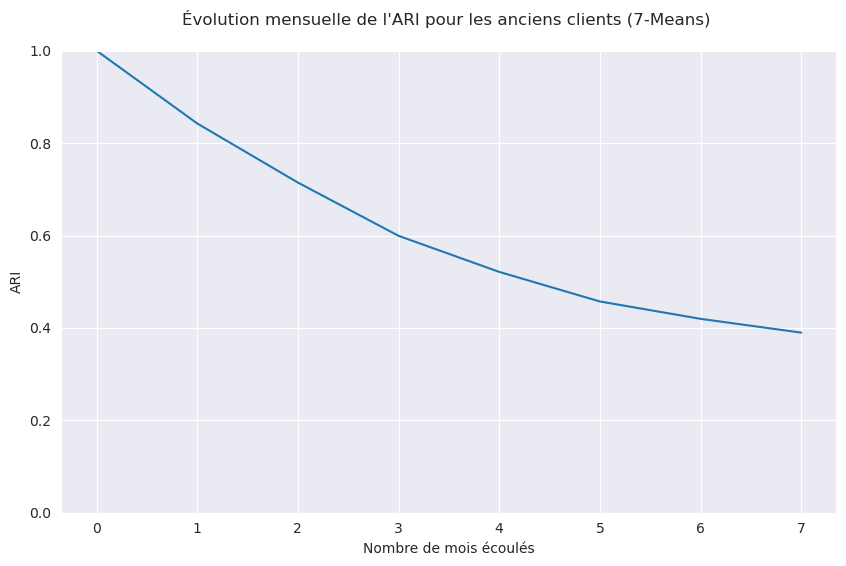

In [15]:
plt.figure(figsize=(10,6))
plt.plot([x for x in range(cnt)], evol_ARI)
plt.title("Évolution mensuelle de l'ARI pour les anciens clients (7-Means) \n")
plt.xlabel("Nombre de mois écoulés")
plt.ylabel("ARI")
plt.ylim(0, 1)
plt.show()

Le premier mois, 84% de notre clusterisation est maintenue (les permutations ne sont pas comptabilisées dans le Rand score). Au deuxième mois, on est à 71%, et au troisième, on passe a 59%.

__Au plus tard, notre maintenance régulière doit être realisée tous les deux mois.__ Au-delà, plus de 40% de nos client auront changé de clusters.

# Conclusion

k=7 a de meilleures métriques de clusterisation. Les catégories qu'il met en valeur sont plus détaillées et même l'évolution de son ARI avec le temps est meilleur que pour k=6.

Pour être sûr de la stabilité de la clusterisation, on va la répéter plusieurs fois avec un random_state non fixe, et on va mesurer l'ARI entre la clusterisation initiale et les clusterisation suivantes..

In [16]:
sdf = creer_tableau_synthese(df_ini=df, date_ref=df['order_purchase_timestamp'].max())
dfw = sdf.drop(columns=['client', 'categorie_produit_preferee', 'reducs', 'montant_reducs'])
dfw.head(2)

,depense,nbcommandes,recence,avis_moyen,nb_items_moyen
0,141.90,1,111,5.0,1.0
1,27.19,1,114,4.0,1.0


In [17]:
X = dfw.values
X_scaled = StandardScaler().fit_transform(X)

In [18]:
resultats = pd.DataFrame()

for i in range(0, 50) :
    model = KMeans(n_init = KMEANS_NINIT, n_clusters=n_clusters)
    model.fit(X_scaled)
    # Sauvegarder les resultats
    resultats.loc[:, f'labels_iter_{i}'] = model.predict(X_scaled)

In [19]:
evol_ARI = []
cnt = 0
labels_initiaux = resultats['labels_iter_0']
for col in resultats.iloc[:, 1:].columns :
    evol_ARI.append(adjusted_rand_score(labels_initiaux, resultats[col]))
    cnt += 1

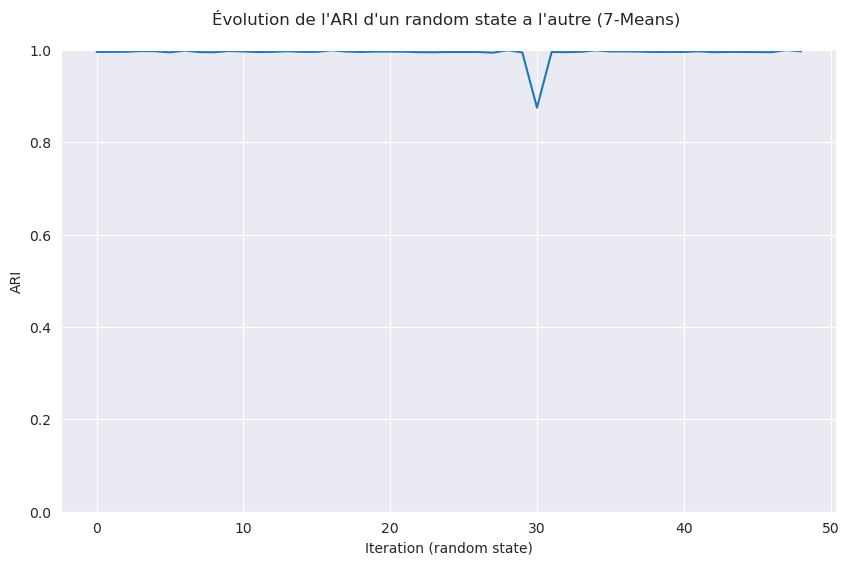

In [20]:
plt.figure(figsize=(10,6))
plt.plot([x for x in range(cnt)], evol_ARI)
plt.title("Évolution de l'ARI d'un random state a l'autre (7-Means) \n")
plt.xlabel("Iteration (random state)")
plt.ylabel("ARI")
plt.ylim(0, 1)
plt.show()

Sur nos 50 itérations, la clusterisation varie peu (à la permutation près - cf. calcul d'ARI), en fonction de notre _random_state_. __Notre clusterisation est stable.__

# RFM

La RFM etant une clusterisation ou la recence a un role determinant, on peut supposer qu'elle devienne rapidement obsolete. L'objectif de ce chapitre est de le demontrer.

In [21]:
import seaborn as sns

In [22]:
df = pd.read_csv('./data_travail/df_merged.csv')
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'],yearfirst=True)
df.head(2)

,order_id,customer_id,order_purchase_timestamp,customer_unique_id,customer_state,nb_items,cat_produit,reducs,montant_reducs,payment_value,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,SP,1.0,housewares,2.0,20.59,38.71,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,Autres,1.0,perfumery,0.0,0.00,141.46,4.0


In [23]:
DATEREF = max(df['order_purchase_timestamp'])
synthese_df = creer_tableau_synthese(df_ini=df, date_ref=DATEREF)
synthese_df.head(2)

,client,depense,nbcommandes,recence,avis_moyen,nb_items_moyen,reducs,montant_reducs,categorie_produit_preferee
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,1,111,5.0,1.0,0.0,0.0,bed_bath_table
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,114,4.0,1.0,0.0,0.0,health_beauty


In [24]:
def RFM_score(df, label_name = "note_RFM") :
    dfres = df

    # Creer un note de recence
    dfres['segments_R'] = pd.qcut(df['recence'], 4)
    dfres['note_R'] = pd.qcut(df['recence'], 4, labels=False)
    dfres['segments_R'].value_counts()
    # S'assurer que la note la plus elevee correspond a la recence la plus petite
    dfres.loc[dfres['note_R']==0, 'note_R'] = 4
    dfres.loc[dfres['note_R']==3, 'note_R'] = 0
    dfres.loc[dfres['note_R']==4, 'note_R'] = 3
    dfres.loc[dfres['note_R']==2, 'note_R'] = 4
    dfres.loc[dfres['note_R']==1, 'note_R'] = 2
    dfres.loc[dfres['note_R']==4, 'note_R'] = 1

    # Creer note de frequence
    dfres['note_F'] = 1
    dfres.loc[dfres['nbcommandes'] > 1, 'note_F'] = 2

    # Creer note Montant
    dfres['segments_M'] = pd.qcut(dfres['depense'], 4)
    dfres['note_M'] = pd.qcut(dfres['depense'], 4, labels=False)

    dfres[label_name] = dfres['note_R'] + dfres['note_F'] + dfres['note_M']
    return dfres

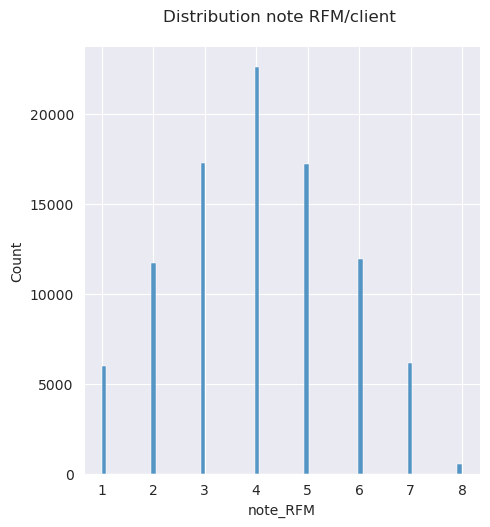

In [25]:
synthese_df = RFM_score(df=synthese_df)
sns.displot(data = synthese_df, x='note_RFM')
plt.title("Distribution note RFM/client \n")
plt.show()

In [26]:
date_seuil_0 = dt.datetime(2018, 1, 1, 0, 0, 0)
df_t0 = df[df['order_purchase_timestamp'] < date_seuil_0]
print("Nb commandes sous date seuil : ", df_t0.shape[0])

Nb commandes sous date seuil :  43695


In [27]:
ref_clients = pd.DataFrame()
ref_clients['client'] = synthese_df['client']
new_date = date_seuil_0

for i in range(0, 8) : 
    # Faire evoluer la date
    new_date = date_seuil_0 + relativedelta(months=i)
    DATEREF = new_date
    # Faire evoluer le tableau de commandes
    df_current = df[df['order_purchase_timestamp'] < DATEREF]
    # Generer une nouvelle synthese client
    sdf = creer_tableau_synthese(df_ini=df_current, date_ref=DATEREF)
    # Realiser un clustering
    sdf = RFM_score(df=sdf)
    ref_clients = ref_clients.merge(sdf[['client', 'note_RFM']], on='client', how='left')
    ref_clients.rename(columns={'note_RFM' : f'note_RFM_{i}'}, inplace=True)

In [28]:
anciens_clients = ref_clients[~ref_clients['note_RFM_0'].isna()]

In [29]:
evol_ARI = []
cnt = 0
labels_initiaux = anciens_clients['note_RFM_0']
for col in anciens_clients.iloc[:, 1:].columns :
    evol_ARI.append(adjusted_rand_score(labels_initiaux, anciens_clients[col]))
    cnt += 1

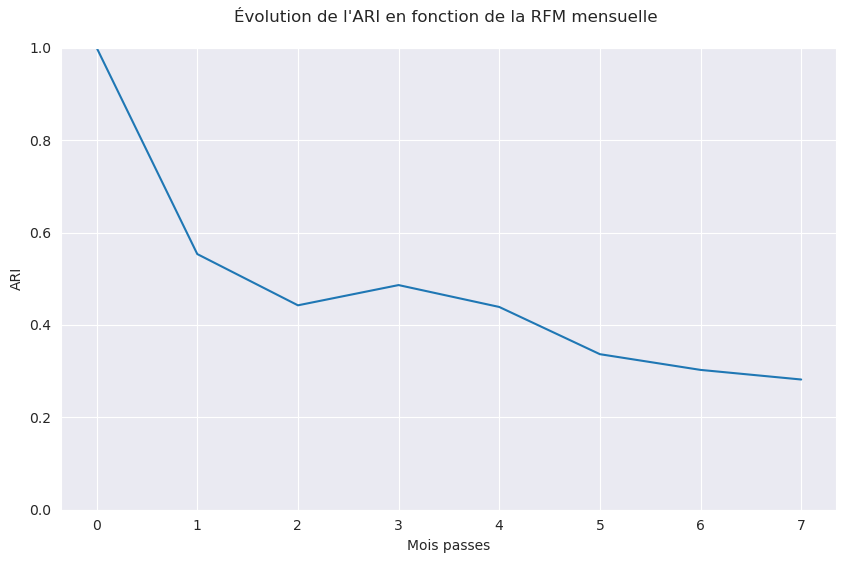

In [30]:
plt.figure(figsize=(10,6))
plt.plot([x for x in range(cnt)], evol_ARI)
plt.title("Évolution de l'ARI en fonction de la RFM mensuelle \n")
plt.xlabel("Mois passes")
plt.ylabel("ARI")
plt.ylim(0, 1)
plt.show()